# 1. Load the dataset (X and Y vector)

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns 

DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [4]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path, 0) #Load the gray image
            #Resizing
            img = cv2.resize(src=img, dsize=img_shape)
            #Normalization
            img = img/255
            #Add the image in the feature matrix and its labels to the label vector
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y

labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

Feature matrix : 
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.36078431 0.38823529 0.38039216 ... 0.70588235 0.72156863 0.60784314]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


# 2. Pipelines

In [5]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
# Models import
# Scoring
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# PCA
from sklearn.decomposition import PCA

In [6]:
def pca_per_class(X, n_components):
    """
    Create another dataset by selecting the n_components the most correlated for each class by using PCA for each class
    :param X: the inital matrix feature
    :param n_components: number of components to keep for each class
    :return: X_pca : the new matrix feature
    """
    pca_classes = [] #list with the PCA instance for each class
    for i in range(len(labels)):
        idx_samples = np.argwhere(Y == i)[:, 0]
        X_class_i = X[idx_samples, :] # keep only the samples for the class i
        #Instanciate the PCA
        pca_i = PCA(n_components=n_components)
        #Train the PCA
        pca_i.fit_transform(X_class_i)
        #Add to the list
        pca_classes.append(pca_i)
    #Transform the inital matrix feature with the PCA of the first class
    X_pca = pca_classes[0].transform(X)
    #Concatenate the other transform matrix to create the new matrix feature
    for i in range(1, len(labels)):
        X_pca_i = pca_classes[i].transform(X)
        X_pca = np.concatenate((X_pca, X_pca_i), axis=1)
    return X_pca

X_pca_10 = pca_per_class(X, 10)

In [7]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score


kmeans = [silhouette_score(X_pca_10, KMeans(n_clusters=i).fit_predict(X_pca_10)) for i in range(3, 33, 3)]
gaussmix = [silhouette_score(X_pca_10, GaussianMixture(n_components=i).fit_predict(X_pca_10)) for i in range(3, 33, 3)]
bayesmix = [silhouette_score(X_pca_10, BayesianGaussianMixture(n_components=i).fit_predict(X_pca_10)) for i in range(3, 33, 3)]

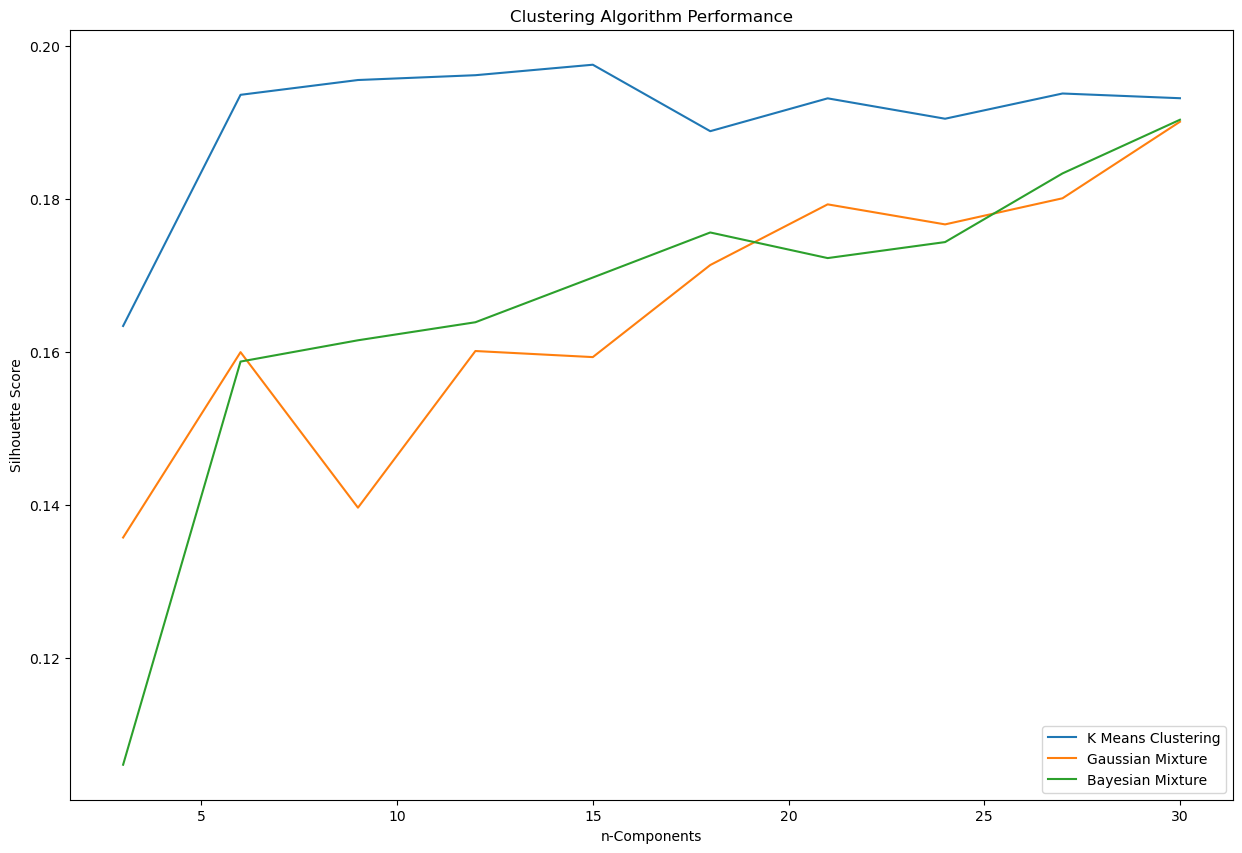

In [8]:
plt.figure(figsize=(15,10))
plt.title('Clustering Algorithm Performance')
plt.ylabel('Silhouette Score')
plt.xlabel('n-Components')
plt.plot(range(3,33, 3), kmeans, label='K Means Clustering')
plt.plot(range(3,33, 3), gaussmix, label='Gaussian Mixture')
plt.plot(range(3,33, 3), bayesmix, label='Bayesian Mixture')
plt.legend()


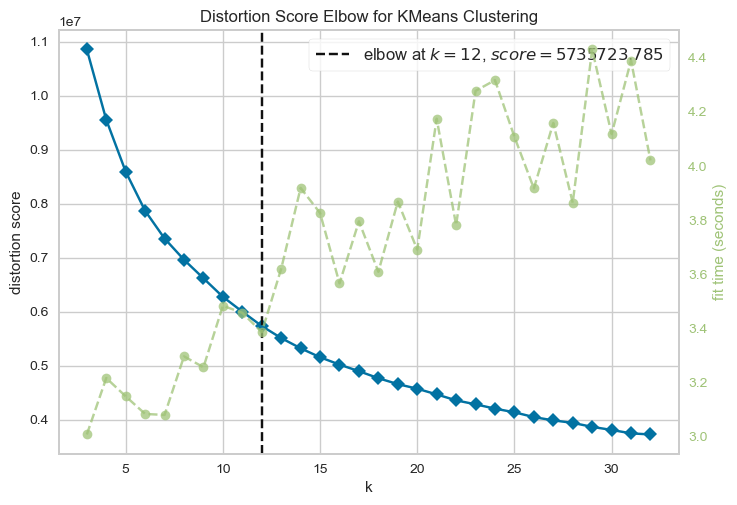

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,33))

visualizer.fit(X_pca_10)
visualizer.show()